# Exploración y analisis de modelos entrenados - comparación iespnet contra dsf-iespnet

In [2]:
import pandas   as pd
import numpy    as np
import seaborn  as sns

import matplotlib.pyplot        as plt
import matplotlib.font_manager  as fm

from matplotlib.lines import Line2D

In [5]:
meta_data_lopo    = '/media/martin/Disco2/Rns_Data/PITT_PI_EEG/METADATA/allfiles_metadata.csv'
meta_data_iespnet = '/media/martin/Disco2/Rns_Data/PITT_PI_SPEC/METADATA/allfiles_metadata.csv'

df_meta_lopo    = pd.read_csv(meta_data_lopo)
df_meta_iespnet = pd.read_csv(meta_data_iespnet)

In [6]:
patients_lopo     = df_meta_lopo['rns_id'].unique().tolist()
save_path_lopo    = '/media/martin/Disco2/Rns_Data/experimentos/dsf_iespnet_lopo/'

patients_iespnet  = df_meta_iespnet['rns_id'].unique().tolist()
save_path_iespnet = '/media/martin/Disco2/Rns_Data/models/modelo-30-noprocess/'

In [7]:
print(patients_lopo)
print(patients_iespnet)

['PIT-RNS1603', 'PIT-RNS6989', 'PIT-RNS3016', 'PIT-RNS1529', 'PIT-RNS7168', 'PIT-RNS4098', 'PIT-RNS1836', 'PIT-RNS9183', 'PIT-RNS1440', 'PIT-RNS1713', 'PIT-RNS9536', 'PIT-RNS2543', 'PIT-RNS1438', 'PIT-RNS1534', 'PIT-RNS1703', 'PIT-RNS1556', 'PIT-RNS1597', 'PIT-RNS6992', 'PIT-RNS8326', 'PIT-RNS2227', 'PIT-RNS8163', 'PIT-RNS8973', 'PIT-RNS6806', 'PIT-RNS1090', 'PIT-RNS2368', 'PIT-RNS6762', 'PIT-RNS2938', 'PIT-RNS7525', 'PIT-RNS0427', 'PIT-RNS8076']
['PIT-RNS1603', 'PIT-RNS6989', 'PIT-RNS3016', 'PIT-RNS1529', 'PIT-RNS7168', 'PIT-RNS4098', 'PIT-RNS1836', 'PIT-RNS9183', 'PIT-RNS1440', 'PIT-RNS1713', 'PIT-RNS9536', 'PIT-RNS2543', 'PIT-RNS1438', 'PIT-RNS1534', 'PIT-RNS1703', 'PIT-RNS1556', 'PIT-RNS1597', 'PIT-RNS6992', 'PIT-RNS8326', 'PIT-RNS2227', 'PIT-RNS8163', 'PIT-RNS8973', 'PIT-RNS6806', 'PIT-RNS1090', 'PIT-RNS2368', 'PIT-RNS6762', 'PIT-RNS2938', 'PIT-RNS7525', 'PIT-RNS0427', 'PIT-RNS8076']


In [11]:
# save models
save_models_lopo = []
for s in range(len(patients_lopo)):
    save_models_lopo.append(save_path_lopo + patients_lopo[s] + '/models/'+ 'model.pth')
print(save_models_lopo)

save_models_iespnet = []
for s in range(len(patients_iespnet)):
    save_models_iespnet.append(save_path_iespnet + patients_iespnet[s] + '/models/'+ 'model.pth')
print(save_models_iespnet)

print()

# save results
save_results_lopo = []
for s in range(len(patients_lopo)):
    save_results_lopo.append(save_path_lopo + patients_lopo[s] + '/results/' + 'results.npy')
print(save_results_lopo)

save_results_iespnet = []
for s in range(len(patients_iespnet)):
    save_results_iespnet.append(save_path_iespnet + patients_iespnet[s] + '/results/' + patients_iespnet[s] + 'results.npy')
print(save_results_iespnet)

['/media/martin/Disco2/Rns_Data/experimentos/dsf_iespnet_lopo/PIT-RNS1603/models/model.pth', '/media/martin/Disco2/Rns_Data/experimentos/dsf_iespnet_lopo/PIT-RNS6989/models/model.pth', '/media/martin/Disco2/Rns_Data/experimentos/dsf_iespnet_lopo/PIT-RNS3016/models/model.pth', '/media/martin/Disco2/Rns_Data/experimentos/dsf_iespnet_lopo/PIT-RNS1529/models/model.pth', '/media/martin/Disco2/Rns_Data/experimentos/dsf_iespnet_lopo/PIT-RNS7168/models/model.pth', '/media/martin/Disco2/Rns_Data/experimentos/dsf_iespnet_lopo/PIT-RNS4098/models/model.pth', '/media/martin/Disco2/Rns_Data/experimentos/dsf_iespnet_lopo/PIT-RNS1836/models/model.pth', '/media/martin/Disco2/Rns_Data/experimentos/dsf_iespnet_lopo/PIT-RNS9183/models/model.pth', '/media/martin/Disco2/Rns_Data/experimentos/dsf_iespnet_lopo/PIT-RNS1440/models/model.pth', '/media/martin/Disco2/Rns_Data/experimentos/dsf_iespnet_lopo/PIT-RNS1713/models/model.pth', '/media/martin/Disco2/Rns_Data/experimentos/dsf_iespnet_lopo/PIT-RNS9536/models

In [12]:
results_lopo=[]
for s in range(len(save_results_lopo)):
    results_lopo.append(np.load(save_results_lopo[s],allow_pickle=True).item())


results_iespnet=[]
for s in range(len(save_results_iespnet)):
    results_iespnet.append(np.load(save_results_iespnet[s],allow_pickle=True).item())

In [13]:
print(results_lopo[0].keys())
print(results_iespnet[0].keys())

dict_keys(['train_losses', 'valid_losses', 'prediction_tr', 'prediction_te', 'hparams', 'threshold', 'train_size'])
dict_keys(['train_losses', 'train_acupr', 'prediction_te', 'prediction_tr', 'hparams', 'threshold', 'train_size'])


In [14]:
prediction_te_lopo = []
for s in range (len(results_lopo)):
    prediction_te_lopo.append(results_lopo[s].get('prediction_te'))


prediction_te_iespnet = []
for s in range (len(results_iespnet)):
    prediction_te_iespnet.append(results_iespnet[s].get('prediction_te'))
    

In [15]:
print(prediction_te_lopo[0].keys())
print(prediction_te_iespnet[0].keys())

dict_keys(['accuracy', 'f1', 'precision', 'recall', 'y_true', 'y_pred', 't_true', 't_pred', 'l_true', 'l_pred', 'proba', 'MAE_time'])
dict_keys(['accuracy', 'f1', 'precision', 'recall', 'y_true', 'y_pred', 't_true', 't_pred', 'l_true', 'l_pred', 'proba', 'MAE_time'])


In [16]:
accuracy_lopo = []
for s in range (len(prediction_te_lopo)):
    accuracy_lopo.append(float(prediction_te_lopo[s].get('accuracy')))
    
f1_lopo = []
for s in range (len(prediction_te_lopo)):
    f1_lopo.append(float(prediction_te_lopo[s].get('f1')))

MAE_time_lopo = []
for s in range (len(prediction_te_lopo)):
    MAE_time_lopo.append(prediction_te_lopo[s].get('MAE_time'))

In [17]:
none_indices = [i for i, x in enumerate(MAE_time_lopo) if x is None]

# Imprimir los índices
print("Índices con None:", none_indices)

Índices con None: []


In [18]:
accuracy_iespnet = []
for s in range (len(prediction_te_iespnet)):
    accuracy_iespnet.append(float(prediction_te_iespnet[s].get('accuracy')))
    
f1_iespnet = []
for s in range (len(prediction_te_iespnet)):
    f1_iespnet.append(float(prediction_te_iespnet[s].get('f1')))

MAE_time_iespnet = []
for s in range (len(prediction_te_iespnet)):
    MAE_time_iespnet.append(prediction_te_iespnet[s].get('MAE_time'))

In [19]:
none_indices = [i for i, x in enumerate(MAE_time_iespnet) if x is None]

# Imprimir los índices
print("Índices con None:", none_indices)

Índices con None: []


In [20]:
for s in range (len(MAE_time_lopo)):
    float(MAE_time_lopo[s])

In [21]:
for s in range (len(MAE_time_iespnet)):
    float(MAE_time_iespnet[s])

In [27]:
print(patients_lopo.index('PIT-RNS0427'),
      patients_lopo.index('PIT-RNS1713'),  
      patients_lopo.index('PIT-RNS3016'),
      patients_lopo.index('PIT-RNS7168'),
      patients_lopo.index('PIT-RNS8326'),
      patients_lopo.index('PIT-RNS6762'),
     )

28 9 2 4 18 25


## Boxplot

/tmp/ipykernel_10746/2820909621.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontproperties = montserrat, fontsize = 14)
/tmp/ipykernel_10746/2820909621.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontproperties = montserrat, fontsize = 14)


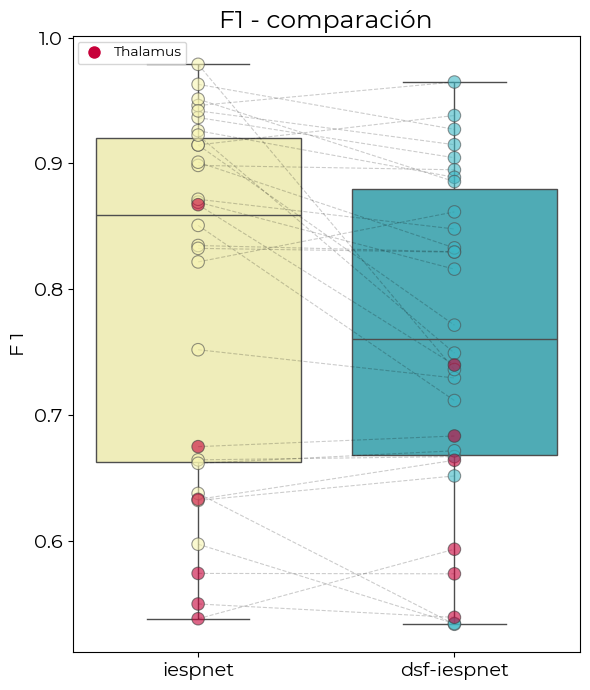

In [29]:
df = pd.DataFrame({'iespnet': f1_iespnet, 'dsf-iespnet': f1_lopo})

font_path        = '../03-Letra-plot/Montserrat-Regular.ttf'
montserrat       = fm.FontProperties(fname = font_path)

indices_thalamus = [2, 4, 9, 18, 25, 28]
thalamus_data    = df.loc[indices_thalamus]  

plt.figure(figsize = (6, 7), facecolor='white')

# Configurar colores personalizados para la cuadrícula
plt.rc('grid',   color='#CFCFCF', linestyle='--', linewidth=0.7)
plt.rc('axes',   facecolor='white')

# Crea el box plot
sns.boxplot( data = df, palette = ["#F8F5B1", "#3EB8C6"])
sns.stripplot(data = df.drop(indices_thalamus), size=9, jitter = False, linewidth = 0.8, alpha = 0.6, palette = ['#F8F5B1', '#3EB8C6'])
sns.stripplot(data = thalamus_data, size = 9, jitter = False, linewidth = 0.8, alpha = 0.6, palette = ['#C70039', '#C70039'])

#leyenda
thalamus_legend = Line2D([0], [0], marker = 'o', color = 'w', markerfacecolor = '#C70039', markersize = 10, label = "Thalamus")
legend=plt.legend(handles = [thalamus_legend], loc = 'upper left', prop = {'size': 8})
for text in legend.get_texts():
    text.set_fontproperties(montserrat)


for i in range(len(f1_lopo)):
    plt.plot([0, 1], [f1_iespnet[i], f1_lopo[i]], linestyle='--', linewidth=0.8, alpha=0.2, color='black')

plt.title('F1 - comparación', fontproperties = montserrat, fontsize = 18, color = 'black')
plt.ylabel('F 1', fontproperties = montserrat, fontsize = 14,color = 'black')


# Aplicar la fuente Montserrat a las etiquetas de los ejes
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), fontproperties = montserrat, fontsize = 14)
ax.set_yticklabels(ax.get_yticklabels(), fontproperties = montserrat, fontsize = 14)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

/tmp/ipykernel_10746/3061261415.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontproperties=montserrat, fontsize=14)
/tmp/ipykernel_10746/3061261415.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontproperties=montserrat, fontsize=14)


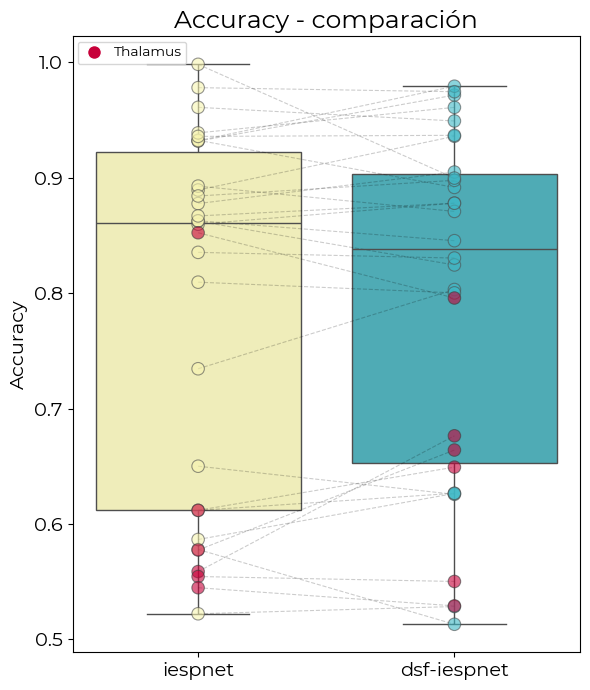

In [30]:
df = pd.DataFrame({'iespnet': accuracy_iespnet, 'dsf-iespnet': accuracy_lopo})

font_path        = '../03-Letra-plot/Montserrat-Regular.ttf'
montserrat       = fm.FontProperties(fname=font_path)

indices_thalamus = [2, 4, 9, 18, 25, 28]
thalamus_data    = df.loc[indices_thalamus]  

plt.figure(figsize = (6, 7), facecolor = 'white')

# Configurar colores personalizados para la cuadrícula
plt.rc('grid', color = '#CFCFCF', linestyle = '--', linewidth = 0.7)
plt.rc('axes', facecolor = 'white')

# Crea el box plot
sns.boxplot(data = df, palette = ["#F8F5B1", "#3EB8C6"])
sns.stripplot(data = df.drop(indices_thalamus), size = 9, jitter = False, linewidth = 0.8, alpha = 0.6, palette = ['#F8F5B1', '#3EB8C6'])
sns.stripplot(data = thalamus_data, size = 9, jitter = False, linewidth = 0.8, alpha = 0.6, palette = ['#C70039', '#C70039'])

#leyenda
thalamus_legend = Line2D([0], [0], marker = 'o', color = 'w', markerfacecolor = '#C70039', markersize = 10, label = "Thalamus")
legend = plt.legend(handles=[thalamus_legend], loc='upper left',prop={'size': 8})
for text in legend.get_texts():
    text.set_fontproperties(montserrat)


for i in range(len(accuracy_lopo)):
    plt.plot([0, 1], [accuracy_iespnet[i], accuracy_lopo[i]], linestyle = '--', linewidth = 0.8, alpha = 0.2, color = 'black')

plt.title('Accuracy - comparación', fontproperties = montserrat, fontsize = 18, color = 'black')
plt.ylabel('Accuracy', fontproperties = montserrat, fontsize = 14,color = 'black')


# Aplicar la fuente Montserrat a las etiquetas de los ejes
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), fontproperties=montserrat, fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), fontproperties=montserrat, fontsize=14)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

/tmp/ipykernel_10746/2323479495.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontproperties = montserrat, fontsize = 14)
/tmp/ipykernel_10746/2323479495.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontproperties = montserrat, fontsize = 14)


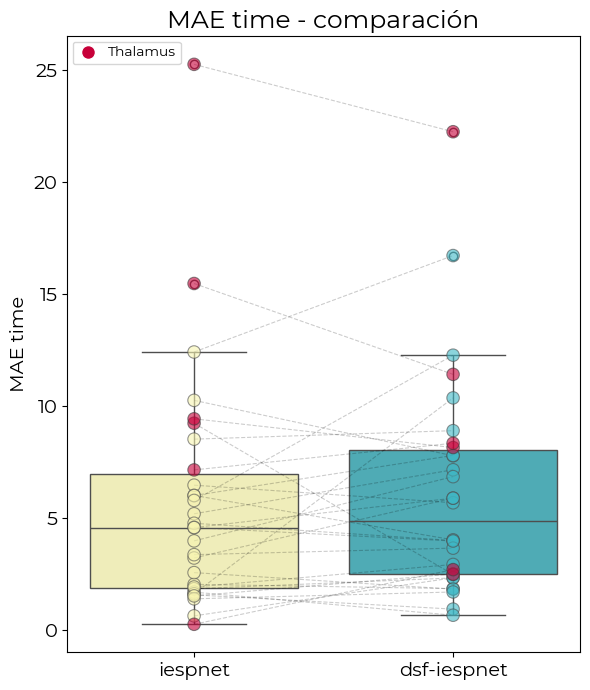

In [34]:
df = pd.DataFrame({'iespnet': MAE_time_iespnet, 'dsf-iespnet': MAE_time_lopo})

font_path        = '../03-Letra-plot/Montserrat-Regular.ttf'
montserrat       = fm.FontProperties(fname=font_path)

indices_thalamus = [2, 4, 9, 18, 25, 28]
thalamus_data    = df.loc[indices_thalamus]  

plt.figure(figsize = (6, 7), facecolor = 'white')

# Configurar colores personalizados para la cuadrícula
plt.rc('grid', color = '#CFCFCF', linestyle = '--', linewidth = 0.7)
plt.rc('axes', facecolor = 'white')

# Crea el box plot
sns.boxplot(data = df, palette = ["#F8F5B1", "#3EB8C6"])
sns.stripplot(data = df.drop(indices_thalamus), size = 9, jitter = False, linewidth = 0.8, alpha = 0.6, palette = ['#F8F5B1', '#3EB8C6'])
sns.stripplot(data = thalamus_data, size = 9, jitter = False, linewidth = 0.8, alpha = 0.6, palette = ['#C70039', '#C70039'])

#leyenda
thalamus_legend = Line2D([0], [0], marker = 'o', color = 'w', markerfacecolor = '#C70039', markersize = 10, label = "Thalamus")
legend=plt.legend(handles = [thalamus_legend], loc = 'upper left',prop = {'size': 8})
for text in legend.get_texts():
    text.set_fontproperties(montserrat)


for i in range(len(MAE_time_lopo)):
    plt.plot([0, 1], [MAE_time_iespnet[i], MAE_time_lopo[i]], linestyle='--', linewidth = 0.8, alpha = 0.2, color = 'black')

plt.title('MAE time - comparación', fontproperties = montserrat, fontsize = 18, color = 'black')
plt.ylabel('MAE time', fontproperties = montserrat, fontsize = 14,color = 'black')


# Aplicar la fuente Montserrat a las etiquetas de los ejes
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), fontproperties = montserrat, fontsize = 14)
ax.set_yticklabels(ax.get_yticklabels(), fontproperties = montserrat, fontsize = 14)

# Mostrar el gráfico
plt.tight_layout()
plt.show()